## Data Analysis (Yellow Taxi Kaggle Dataset)

### 1. Install Packages and download dataset from Kaggle 

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download elemento/nyc-yellow-taxi-trip-data
! unzip nyc-yellow-taxi-trip-data.zip

Dataset URL: https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data
License(s): U.S. Government Works
100% 1.78G/1.78G [00:18<00:00, 154MB/s]
100% 1.78G/1.78G [00:18<00:00, 104MB/s]
Archive:  nyc-yellow-taxi-trip-data.zip
  inflating: yellow_tripdata_2015-01.csv  
  inflating: yellow_tripdata_2016-01.csv  
  inflating: yellow_tripdata_2016-02.csv  
  inflating: yellow_tripdata_2016-03.csv  


In [ ]:
!pip install pyspark
!pip install findspark

import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=773f1a8a7142b37c923bf733035146b859eb7ee57d3d9fa8460a644d2fa93e5c
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


### Step 2. Read in and clean dataset

In [ ]:
df1 = spark.read.format("csv").option("header", "true").load('/content/yellow_tripdata_2015-01.csv')
df2 = spark.read.format("csv").option("header", "true").load('/content/yellow_tripdata_2016-02.csv')
df = df1.unionByName(df2)
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2015-01-15 19:05:39|  2015-01-15 19:23:42|              1|         1.59|   -73.993896484375|40.750110626220703|        

Handles missing values

In [ ]:
from pyspark.sql.functions import col

# Handles missing values
df_cleaned = df.na.drop(subset=["fare_amount", "trip_distance", "passenger_count"])

# Filters out invalid data
df_cleaned = df_cleaned.filter((col("fare_amount") < 0) | (col("trip_distance") == 0))
df_cleaned.show(5)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2015-01-10 20:33:39|  2015-01-10 20:35:31|              1|          .50|-74.009086608886719|40.713817596435547|        

### Step 3: Add new features

In [ ]:
from pyspark.sql.functions import to_timestamp, unix_timestamp

# Converts to timestamp data types
df_cleaned = df_cleaned.withColumn("pickup_datetime", to_timestamp(col("tpep_pickup_datetime")))
df_cleaned = df_cleaned.withColumn("dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime")))
df_cleaned.show(5)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|    pickup_datetime|   dropoff_datetime|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+-------------------+
|       1|

In [ ]:
# Adds trip duration column (in minutes) using unix_timestamp
df_cleaned = df_cleaned.withColumn("trip_duration", (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60)
df_cleaned.show(5)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+-------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|    pickup_datetime|   dropoff_datetime|     trip_duration|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------

In [ ]:
from pyspark.sql.functions import hour, dayofweek

df_cleaned = df_cleaned.withColumn("pickup_hour", hour(col("pickup_datetime")))
df_cleaned = df_cleaned.withColumn("pickup_day", dayofweek(col("pickup_datetime")))
df_cleaned.show(5)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+-------------------+------------------+-----------+----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|    pickup_datetime|   dropoff_datetime|     trip_duration|pickup_hour|pickup_day|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+--

### Step 4: Data visualizations of cleaned data

+----+-----------------+
|year|avg_trip_duration|
+----+-----------------+
|2015|6.509705661030339|
+----+-----------------+



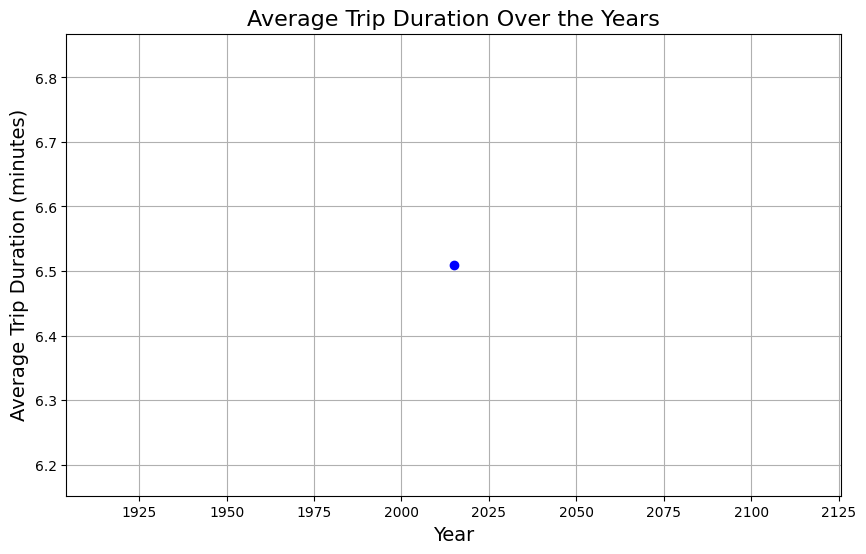

In [ ]:
from pyspark.sql.functions import year, avg
import matplotlib.pyplot as plt

# Get year and calculate average trip duration
df_cleaned = df_cleaned.withColumn("year", year("pickup_datetime"))
df_avg_duration = df_cleaned.groupBy("year").agg(avg("trip_duration").alias("avg_trip_duration"))
df_avg_duration = df_avg_duration.orderBy("year")
df_avg_duration.show()



# Plotting the average trip duration over the years
df_avg_duration_pd = df_avg_duration.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(df_avg_duration_pd['year'], df_avg_duration_pd['avg_trip_duration'], marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title("Average Trip Duration Over the Years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Trip Duration (minutes)", fontsize=14)
plt.grid(True)
plt.show()

+-----------+----------------------+
|pickup_hour|avg_trip_duration_hour|
+-----------+----------------------+
|          0|     5.524768001276846|
|          1|     5.017110002136555|
|          2|     4.912954009913052|
|          3|     5.129875543518317|
|          4|     4.816087866935325|
|          5|     8.506319115323864|
|          6|    4.1647221680428235|
|          7|      5.05628795401744|
|          8|      5.93456342300179|
|          9|     6.240371106773277|
|         10|     5.931339687231577|
|         11|     5.996416146002626|
|         12|     6.150245375093063|
|         13|    6.1587056487876035|
|         14|     6.314655266694466|
|         15|     19.69255644204644|
|         16|     5.716949309242676|
|         17|     5.808441173488097|
|         18|     5.869167672071332|
|         19|     5.771961463266427|
+-----------+----------------------+
only showing top 20 rows



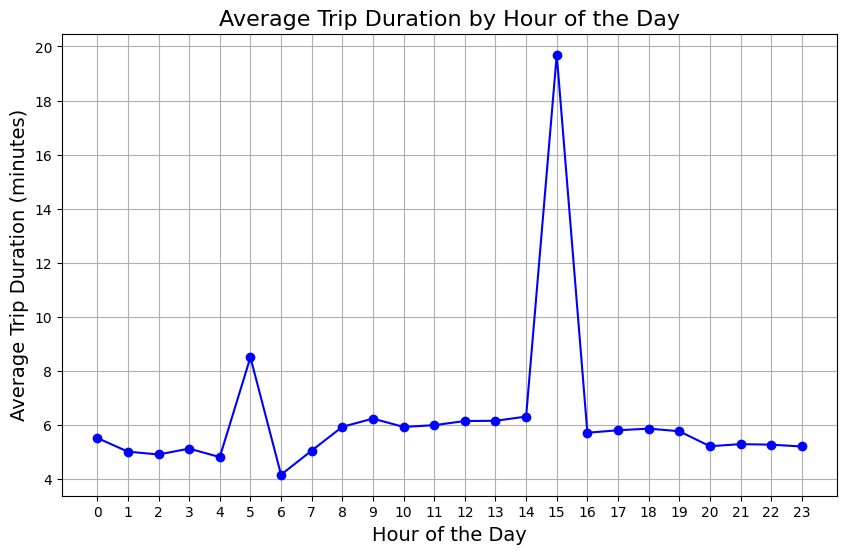

In [ ]:
# Group by the hour and calculate average trip duration
df_avg_duration_by_hour = df_cleaned.groupBy("pickup_hour").agg(avg("trip_duration").alias("avg_trip_duration_hour"))
df_avg_duration_by_hour = df_avg_duration_by_hour.orderBy("pickup_hour")
df_avg_duration_by_hour.show()

# Plotting the average trip duration by hour
df_avg_duration_by_hour_pd = df_avg_duration_by_hour.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(df_avg_duration_by_hour_pd['pickup_hour'], df_avg_duration_by_hour_pd['avg_trip_duration_hour'], marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title("Average Trip Duration by Hour of the Day", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Average Trip Duration (minutes)", fontsize=14)
plt.grid(True)
plt.xticks(range(0, 24))  # Ensure the x-axis shows all 24 hours
plt.show()

+------------------+-------------------+------------+
|   pickup_latitude|   pickup_longitude|pickup_count|
+------------------+-------------------+------------+
|                 0|                  0|      243478|
|40.744899749755859|-73.948638916015625|        1043|
|40.693141937255859|-74.186302185058594|         729|
|  40.7222900390625|-73.986717224121094|         429|
|40.743576049804688|-73.915122985839844|         306|
|40.727676391601563|-74.003143310546875|         233|
|40.691463470458984|-73.921516418457031|         153|
|40.731502532958984|-73.988456726074219|         147|
|  40.6429443359375|-73.978279113769531|         121|
|40.754417419433594|-73.942085266113281|         108|
+------------------+-------------------+------------+
only showing top 10 rows

+------------------+-------------------+-------------+
|  dropoff_latitude|  dropoff_longitude|dropoff_count|
+------------------+-------------------+-------------+
|                 0|                  0|       235318

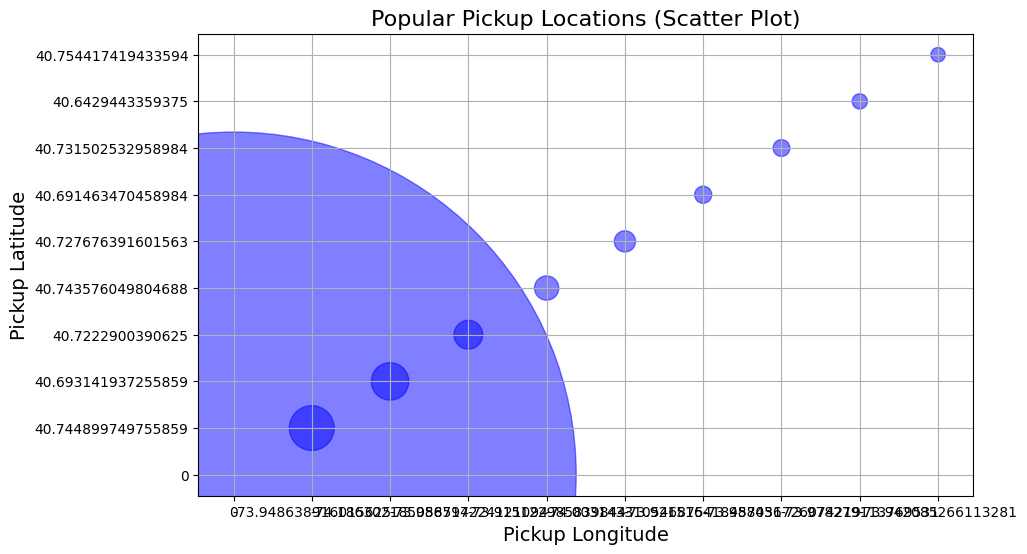

In [ ]:
from pyspark.sql.functions import count, desc
import seaborn as sns

# Group by pickup coordinates and count occurrences
pickup_popularity = df.groupBy("pickup_latitude", "pickup_longitude").agg(count("*").alias("pickup_count")).orderBy(desc("pickup_count"))

# Group by dropoff coordinates and count occurrences
dropoff_popularity = df.groupBy("dropoff_latitude", "dropoff_longitude").agg(count("*").alias("dropoff_count")).orderBy(desc("dropoff_count"))

# Show the most popular pickup and dropoff locations
pickup_popularity.show(10)
dropoff_popularity.show(10)

# Convert to Pandas DataFrames for plotting
pickup_popularity_pd = pickup_popularity.limit(10).toPandas()
dropoff_popularity_pd = dropoff_popularity.limit(10).toPandas()

# Scatter plot of pickup locations
plt.figure(figsize=(10, 6))
plt.scatter(pickup_popularity_pd['pickup_longitude'], pickup_popularity_pd['pickup_latitude'],
            s=pickup_popularity_pd['pickup_count'], alpha=0.5, color='blue')

# Add titles and labels
plt.title("Popular Pickup Locations (Scatter Plot)", fontsize=16)
plt.xlabel("Pickup Longitude", fontsize=14)
plt.ylabel("Pickup Latitude", fontsize=14)
plt.grid(True)
plt.show()

+------------------+-------------------+-----------------+
|   pickup_latitude|   pickup_longitude|         avg_fare|
+------------------+-------------------+-----------------+
|40.711856842041016|-74.014335632324219|           3005.5|
|40.685710906982422|-73.591758728027344|            978.0|
| 40.69195556640625|-73.811416625976563|            965.0|
|40.685993194580078|-73.591827392578125|            965.0|
|40.686080932617188|-73.591835021972656|           949.99|
|40.775882720947266|-73.921890258789063|926.6666666666666|
|40.766242980957031|-73.921928405761719|            900.0|
|40.751655578613281|  -73.9766845703125|            900.0|
|   40.752685546875|-73.976226806640625|            900.0|
|40.717456817626953|-73.993446350097656|            900.0|
+------------------+-------------------+-----------------+
only showing top 10 rows



/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

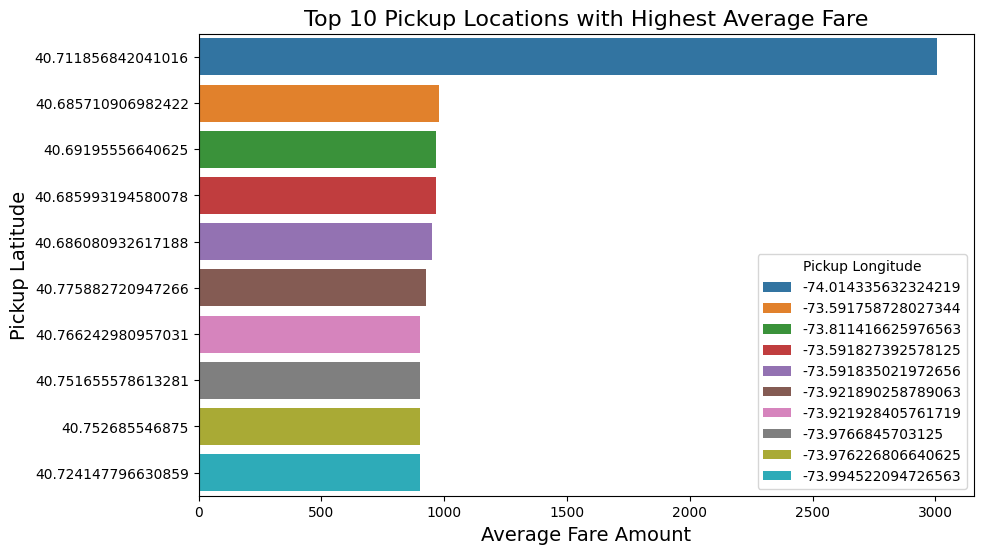

In [ ]:
# Group by pickup coordinates and calculate the average fare
df_avg_fare_by_location = df_cleaned.groupBy("pickup_latitude", "pickup_longitude").agg(avg("fare_amount").alias("avg_fare")).orderBy(desc("avg_fare"))
df_avg_fare_by_location.show(10)

# Convert the result to Pandas DataFrame for plotting
df_avg_fare_by_location_pd = df_avg_fare_by_location.limit(10).toPandas()

# Plotting the top 10 pickup locations with the highest average fare
plt.figure(figsize=(10, 6))
sns.barplot(x="avg_fare", y="pickup_latitude", hue="pickup_longitude", data=df_avg_fare_by_location_pd, dodge=False)

# Add titles and labels
plt.title("Top 10 Pickup Locations with Highest Average Fare", fontsize=16)
plt.xlabel("Average Fare Amount", fontsize=14)
plt.ylabel("Pickup Latitude", fontsize=14)
plt.legend(title="Pickup Longitude")
plt.show()

                     trip_duration  trip_distance_float  fare_amount
trip_duration             1.000000             0.001693     0.002205
trip_distance_float       0.001693             1.000000    -0.070714
fare_amount               0.002205            -0.070714     1.000000


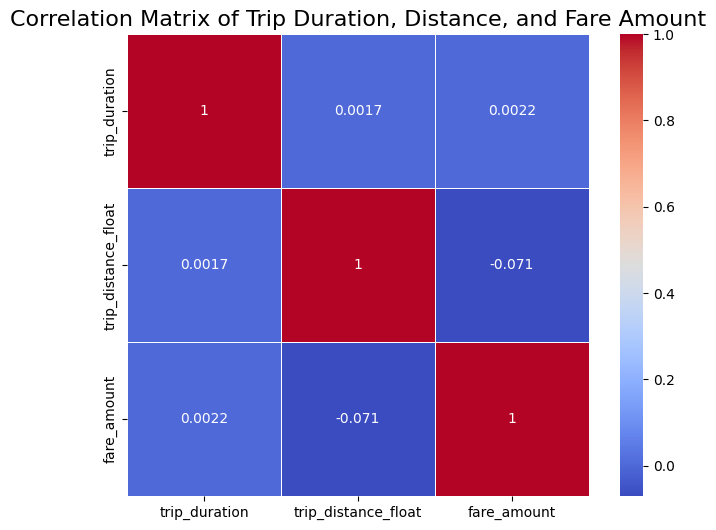

In [ ]:
# Convert to Pandas DataFrame
df_cleaned = df_cleaned.withColumn("trip_distance_float", col("trip_distance").cast("float"))
df_pd = df_cleaned.select("trip_duration", "trip_distance_float", "fare_amount").toPandas()

# Calculate correlation between trip duration and fare amount
correlation_duration_fare = df.stat.corr("trip_duration", "fare_amount")

# Calculate correlation between trip distance and fare amount
correlation_distance_fare = df.stat.corr("trip_distance", "fare_amount")

# Calculate correlation between trip duration and trip distance
correlation_duration_distance = df.stat.corr("trip_duration", "trip_distance")

print(f"Correlation between trip duration and fare amount: {correlation_duration_fare}")
print(f"Correlation between trip distance and fare amount: {correlation_distance_fare}")
print(f"Correlation between trip duration and trip distance: {correlation_duration_distance}")

# Calculate the correlation matrix
correlation_matrix = df_pd.corr()
print(correlation_matrix)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True)
plt.title("Correlation Matrix of Trip Duration, Distance, and Fare Amount", fontsize=16)
plt.show()

In [ ]:
from pyspark.sql.functions import month, concat_ws
import pandas as pd


df_cleaned = df_cleaned.withColumn("year_month", month("pickup_datetime"))
df_cleaned = df_cleaned.withColumn("year_month", concat_ws("-", col("year"), col("month")))
df_monthly_trips = df_cleaned.groupBy("year_month").agg(count("*").alias("trip_count_monthly"))
df_monthly_trips = df_monthly_trips.orderBy("year_month")
df_monthly_trips.show(10)

# Convert to Pandas DataFrame for plotting
df_monthly_trips_pd = df_monthly_trips.toPandas()
df_monthly_trips_pd['year_month'] = pd.to_datetime(df_monthly_trips_pd['year_month'], format='%Y-%m')

# Plot the number of trips over time (monthly)
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='trip_count', data=df_monthly_trips_pd, marker='o')

# Add titles and labels
plt.title("Taxi Demand Over Time (Monthly)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Trips", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `pickup_datetime` cannot be resolved. Did you mean one of the following? [`pickup_latitude`, `tpep_pickup_datetime`, `pickup_longitude`, `tip_amount`, `tpep_dropoff_datetime`].;
'Project [VendorID#2365, tpep_pickup_datetime#2366, tpep_dropoff_datetime#2367, passenger_count#2368, trip_distance#2369, pickup_longitude#2370, pickup_latitude#2371, RateCodeID#2372, store_and_fwd_flag#2373, dropoff_longitude#2374, dropoff_latitude#2375, payment_type#2376, fare_amount#2377, extra#2378, mta_tax#2379, tip_amount#2380, tolls_amount#2381, improvement_surcharge#2382, total_amount#2383, month('pickup_datetime) AS year_month#3239]
+- Filter ((cast(fare_amount#2377 as int) < 0) OR (cast(trip_distance#2369 as int) = 0))
   +- Filter atleastnnonnulls(3, fare_amount#2377, trip_distance#2369, passenger_count#2368)
      +- Union false, false
         :- Relation [VendorID#2365,tpep_pickup_datetime#2366,tpep_dropoff_datetime#2367,passenger_count#2368,trip_distance#2369,pickup_longitude#2370,pickup_latitude#2371,RateCodeID#2372,store_and_fwd_flag#2373,dropoff_longitude#2374,dropoff_latitude#2375,payment_type#2376,fare_amount#2377,extra#2378,mta_tax#2379,tip_amount#2380,tolls_amount#2381,improvement_surcharge#2382,total_amount#2383] csv
         +- Project [VendorID#2420, tpep_pickup_datetime#2421, tpep_dropoff_datetime#2422, passenger_count#2423, trip_distance#2424, pickup_longitude#2425, pickup_latitude#2426, RatecodeID#2427, store_and_fwd_flag#2428, dropoff_longitude#2429, dropoff_latitude#2430, payment_type#2431, fare_amount#2432, extra#2433, mta_tax#2434, tip_amount#2435, tolls_amount#2436, improvement_surcharge#2437, total_amount#2438]
            +- Relation [VendorID#2420,tpep_pickup_datetime#2421,tpep_dropoff_datetime#2422,passenger_count#2423,trip_distance#2424,pickup_longitude#2425,pickup_latitude#2426,RatecodeID#2427,store_and_fwd_flag#2428,dropoff_longitude#2429,dropoff_latitude#2430,payment_type#2431,fare_amount#2432,extra#2433,mta_tax#2434,tip_amount#2435,tolls_amount#2436,improvement_surcharge#2437,total_amount#2438] csv
